 # Step 2B: Apply Naive Classifier to Real Data



 Apply the trained classifier to real tweets to identify high-confidence examples:



 1. Process: Load real tweets, generate embeddings (all-MiniLM-L6-v2), predict classes

 2. Extract: Select top 5000 high-confidence examples per class

 3. Save:

    - High-confidence examples to 'data/high_confidence_real_examples.csv'

    - All examples with embeddings to 'data/all_real_examples_with_embeddings.csv'

 4. Visualize: UMAP projection of high-confidence embeddings



 This step helps identify reliable examples for training our final model.

In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from keras import models
import joblib
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import umap
import matplotlib.pyplot as plt


In [2]:
# Load real data
real_data = pd.read_csv('processed_sentiment140.csv')


In [4]:
# Load the trained model and label encoder
model = models.load_model('tweet_classifier.h5')
le = joblib.load('label_encoder.joblib')


In [5]:
# Load the sentence transformer model
ST_model = SentenceTransformer('all-MiniLM-L6-v2')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
# Generate embeddings for the processed text
print('Generating embeddings for real data...')
batch_size = 32
embeddings = []
for i in tqdm(range(0, len(real_data), batch_size)):
    batch = real_data['cleaned_text'].iloc[i:i+batch_size].tolist()
    batch_embed = ST_model.encode(batch)
    embeddings.extend(batch_embed)
embeddings = np.array(embeddings)


Generating embeddings for real data...


100%|██████████| 31244/31244 [07:14<00:00, 71.90it/s]


In [7]:
# Predict probabilities for each class
print('Predicting class probabilities...')
preds_prob = model.predict(embeddings)
preds = np.argmax(preds_prob, axis=1)
pred_labels = le.inverse_transform(preds)


Predicting class probabilities...
31244/31244 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step


In [8]:
# Add predictions and probabilities to DataFrame
real_data['pred_label'] = pred_labels
real_data['prob_0'] = preds_prob[:, 0]
real_data['prob_1'] = preds_prob[:, 1]


In [9]:
# Add embeddings as a column (as list)
real_data['embedding'] = list(embeddings)


In [10]:
# Select top 5000 for each class by probability
literal_top = real_data[real_data['pred_label'] == le.classes_[0]].nlargest(5000, 'prob_0')
sarcastic_top = real_data[real_data['pred_label'] == le.classes_[1]].nlargest(5000, 'prob_1')
high_conf_examples = pd.concat([literal_top, sarcastic_top], ignore_index=True)
high_conf_examples['high_conf_class'] = high_conf_examples['pred_label']


In [11]:
# Save high confidence examples
output_high_conf = 'high_confidence_real_examples.csv'
high_conf_examples[['text', 'cleaned_text', 'pred_label', 'prob_0', 'prob_1', 'high_conf_class', 'embedding']].to_csv(output_high_conf, index=False)
print(f'High-confidence examples saved to {output_high_conf}')


High-confidence examples saved to high_confidence_real_examples.csv


Reducing high-confidence embeddings to 2D with UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


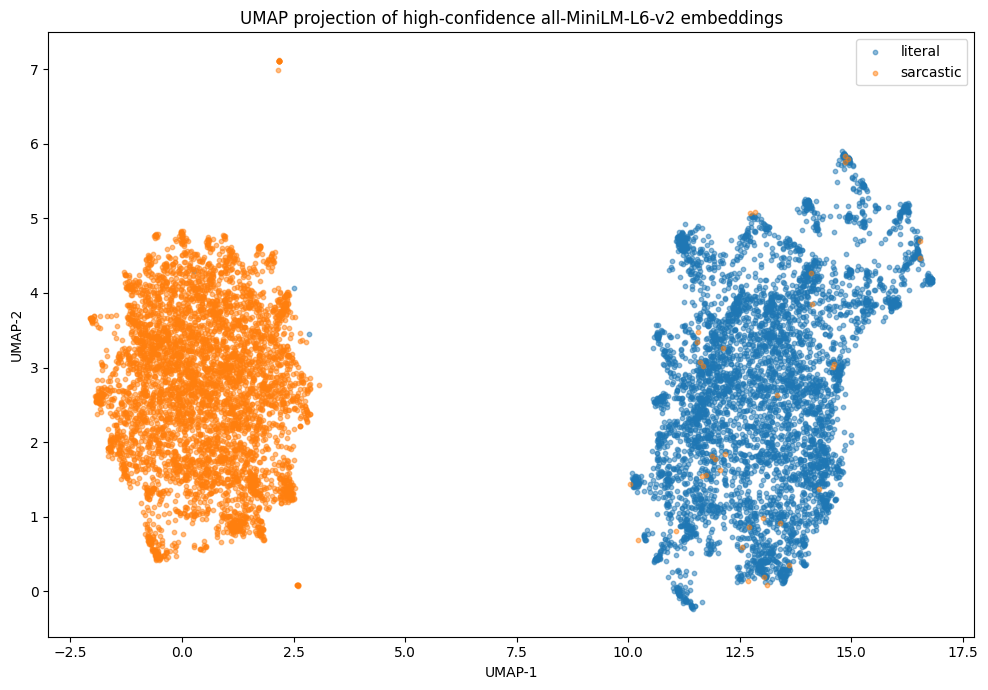

In [12]:
# UMAP visualization of high-confidence embeddings

print("Reducing high-confidence embeddings to 2D with UMAP...")
umap_model = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_model.fit_transform(np.vstack(high_conf_examples['embedding'].values))

# Add 2D coordinates to DataFrame
high_conf_examples['umap_x'] = embeddings_2d[:, 0]
high_conf_examples['umap_y'] = embeddings_2d[:, 1]

# Plot
plt.figure(figsize=(10, 7))
for label in high_conf_examples['high_conf_class'].unique():
    subset = high_conf_examples[high_conf_examples['high_conf_class'] == label]
    plt.scatter(subset['umap_x'], subset['umap_y'], label=label, alpha=0.5, s=10)
plt.legend()
plt.title('UMAP projection of high-confidence all-MiniLM-L6-v2 embeddings')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.tight_layout()
plt.show()
